# Spoofing Detection: Federated RSSI Multilateration

This notebook explains the federated multilateration-based spoofing detection method with Kalman Filter smoothing.

## Intuition

When multiple **federate receivers** (fixed ground stations or designated benign drones) hear the same transmission, each measures a different RSSI based on their distance to the transmitter. We can:

1. Convert each RSSI to a distance estimate
2. Use multilateration to jointly estimate the transmitter's actual position AND TX power
3. Compute the position error (distance between estimated and claimed position)
4. Track the position error over time with a Kalman Filter
5. Use the filtered position error as the detection score

For an **honest transmitter**, estimated ≈ claimed position (small filtered error).

For a **spoofer**, estimated position (based on real RSSI) differs from claimed position (large filtered error).

## Key Design Choices

1. **Fixed federates**: We use the first 4 benign hosts as federate receivers. This simulates a ground station network.
2. **Transmission grouping**: Each transmission is uniquely identified by `(serial_number, rid_timestamp)`. All RX events with matching values came from the same transmission.
3. **Joint estimation**: We solve for both position (x,y,z) AND TX power simultaneously using nonlinear least squares, avoiding the need to assume the claimed position is correct.
4. **Per-transmitter KF tracking**: Each transmitter (identified by serial number) is tracked with its own Kalman Filter for smoothing position error.
5. **Detection score**: The filtered position error magnitude (large error = likely spoofing).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=4, suppress=True)

## Step 1: Path Loss Model (RSSI → Distance)

The log-distance path loss model:

$$RSSI = P_{tx} - 10 \cdot n \cdot \log_{10}(d)$$

Solving for distance:

$$d = 10^{(P_{tx} - RSSI) / (10n)}$$

**Problem:** We don't know the true $P_{tx}$! 

**Old approach:** Assume claimed position is correct, back-calculate TX power.

**New approach:** Jointly estimate position AND TX power using nonlinear least squares.

In [2]:
def rssi_to_distance(rssi, tx_power, path_loss_exp=2.0):
    """Convert RSSI to distance estimate."""
    exponent = (tx_power - rssi) / (10 * path_loss_exp)
    return 10 ** exponent

def distance_to_rssi(distance, tx_power, path_loss_exp=2.0):
    """Expected RSSI at given distance."""
    return tx_power - 10 * path_loss_exp * np.log10(distance)

# Example
tx_power = 15  # dBm
distances = np.array([50, 100, 150, 200])
rssi_values = distance_to_rssi(distances, tx_power)

print("Distance (m) → RSSI (dBm) → Estimated distance (m)")
for d, r in zip(distances, rssi_values):
    d_est = rssi_to_distance(r, tx_power)
    print(f"{d:>8.0f}    → {r:>8.2f}    → {d_est:>8.1f}")

Distance (m) → RSSI (dBm) → Estimated distance (m)
      50    →   -18.98    →     50.0
     100    →   -25.00    →    100.0
     150    →   -28.52    →    150.0
     200    →   -31.02    →    200.0


## Step 2: Joint Position and TX Power Estimation

Given $N$ receivers at positions $\mathbf{r}_i$ with RSSI measurements, we need to find:
- Transmitter position $\mathbf{x} = (x, y, z)$
- TX power $P_{tx}$

The measurement model for each receiver:
$$RSSI_i = P_{tx} - 10n\log_{10}(|\mathbf{x} - \mathbf{r}_i|)$$

This is a nonlinear system with 4 unknowns. With 4+ receivers, it's overdetermined and we solve via nonlinear least squares:

$$\min_{\mathbf{x}, P_{tx}} \sum_i \left( RSSI_i - P_{tx} + 10n\log_{10}(|\mathbf{x} - \mathbf{r}_i|) \right)^2$$

In [3]:
from scipy.optimize import least_squares

def multilaterate_with_tx(receivers, rssi_values, initial_pos, path_loss_exp=2.0):
    """
    Jointly estimate transmitter position and TX power using nonlinear least squares.
    
    Args:
        receivers: (N, 3) array of receiver positions
        rssi_values: (N,) array of RSSI measurements (dBm)
        initial_pos: Initial position guess
        path_loss_exp: Path loss exponent (default 2.0)
    
    Returns:
        Tuple of (estimated_pos, estimated_tx_power)
    """
    n_ple = 10 * path_loss_exp
    
    def residuals(params):
        pos = params[:3]
        tx_power = params[3]
        distances = np.linalg.norm(receivers - pos, axis=1)
        distances = np.maximum(distances, 0.1)  # Avoid log(0)
        expected_rssi = tx_power - n_ple * np.log10(distances)
        return rssi_values - expected_rssi
    
    # Initial guess for TX power
    distances_init = np.linalg.norm(receivers - initial_pos, axis=1)
    distances_init = np.maximum(distances_init, 0.1)
    tx_power_init = np.median(rssi_values + n_ple * np.log10(distances_init))
    x0 = np.concatenate([initial_pos, [tx_power_init]])
    
    result = least_squares(residuals, x0, method='trf', max_nfev=100)
    return result.x[:3], result.x[3]

# Example: 4 receivers
receivers = np.array([
    [0, 0, 50],
    [200, 0, 50],
    [0, 200, 50],
    [200, 200, 50],
])

tx_true = np.array([120, 80, 70])
tx_power_true = 15

# Generate RSSI measurements
true_distances = np.linalg.norm(receivers - tx_true, axis=1)
rssi_values = tx_power_true - 20 * np.log10(true_distances)  # n=2.0

# Add noise
np.random.seed(42)
rssi_noisy = rssi_values + np.random.randn(len(receivers)) * 2

# Solve
tx_est, tx_power_est = multilaterate_with_tx(receivers, rssi_noisy, tx_true)
print(f"True position:      {tx_true}")
print(f"Estimated position: {tx_est}")
print(f"Position error:     {np.linalg.norm(tx_est - tx_true):.2f} m")
print(f"\nTrue TX power:      {tx_power_true} dBm")
print(f"Estimated TX power: {tx_power_est:.2f} dBm")

True position:      [120  80  70]
Estimated position: [128.6009 104.6512 116.4567]
Position error:     53.29 m

True TX power:      15 dBm
Estimated TX power: 17.07 dBm


## Step 3: Federated Detection with KF Filtering

The detection pipeline:

1. **Federate receivers**: Fixed set of 4 benign hosts designated as federates
2. **Per-transmission grouping**: Group RX events by `(serial_number, rid_timestamp)` to identify events from the same transmission
3. **Joint estimation**: Nonlinear least squares solves for position AND TX power simultaneously
4. **Position error**: Compute |estimated_pos - claimed_pos|
5. **KF filtering**: Track position error with a Kalman Filter per transmitter (by serial number)
6. **Detection score**: Filtered position error (large error = likely spoofing)

### Why Kalman Filter?

Raw multilateration is noisy. The KF:
- **Smooths** the error estimate over time
- **Builds confidence** - if error is consistently high, we're more certain it's spoofing
- The KF output is directly the filtered position error magnitude

In [4]:
from scipy.optimize import least_squares

def detect_spoofing(receivers, rssi_values, claimed_pos, path_loss_exp=2.0):
    """
    Compute detection score for a transmission using joint position/TX power estimation.
    
    Instead of assuming claimed position is correct to estimate TX power,
    we jointly solve for (x, y, z, P_tx) using nonlinear least squares.
    
    Returns:
        score: Distance between estimated and claimed position (meters)
        estimated_pos: Multilateration result
        estimated_tx_power: Estimated TX power (dBm)
    """
    n_ple = 10 * path_loss_exp
    
    def residuals(params):
        pos = params[:3]
        tx_power = params[3]
        distances = np.linalg.norm(receivers - pos, axis=1)
        distances = np.maximum(distances, 0.1)  # Avoid log(0)
        expected_rssi = tx_power - n_ple * np.log10(distances)
        return rssi_values - expected_rssi
    
    # Initial guess: claimed position + median TX power estimate
    distances_init = np.linalg.norm(receivers - claimed_pos, axis=1)
    distances_init = np.maximum(distances_init, 0.1)
    tx_power_init = np.median(rssi_values + n_ple * np.log10(distances_init))
    x0 = np.concatenate([claimed_pos, [tx_power_init]])
    
    # Bounds: position anywhere, TX power -50 to 50 dBm
    bounds = ([-np.inf, -np.inf, -np.inf, -50], [np.inf, np.inf, np.inf, 50])
    
    try:
        result = least_squares(residuals, x0, bounds=bounds, method='trf', max_nfev=100)
        if result.success or result.cost < 100:
            estimated_pos = result.x[:3]
            estimated_tx_power = result.x[3]
            score = np.linalg.norm(estimated_pos - claimed_pos)
            return score, estimated_pos, estimated_tx_power
    except:
        pass
    
    return 0.0, None, None

In [5]:
# Test with honest transmitter
tx_true = np.array([120, 80, 70])
tx_power = 15

# Receivers see RSSI based on true distance
true_distances = np.linalg.norm(receivers - tx_true, axis=1)
rssi_values = distance_to_rssi(true_distances, tx_power)

# Add noise
np.random.seed(42)
rssi_noisy = rssi_values + np.random.randn(len(receivers)) * 2  # 2dB noise

# Honest: claimed = true
score, est_pos, est_tx = detect_spoofing(receivers, rssi_noisy, tx_true)
print("HONEST TRANSMITTER")
print(f"True position:      {tx_true}")
print(f"Claimed position:   {tx_true}")
print(f"Estimated position: {est_pos}")
print(f"Estimated TX power: {est_tx:.2f} dBm (true: {tx_power} dBm)")
print(f"Detection score:    {score:.2f} m")

HONEST TRANSMITTER
True position:      [120  80  70]
Claimed position:   [120  80  70]
Estimated position: [123.283  103.7864  48.0991]
Estimated TX power: 16.18 dBm (true: 15 dBm)
Detection score:    32.50 m


In [6]:
# Test with spoofer
tx_actual = np.array([50, 50, 60])  # Where spoofer actually is
tx_claimed = np.array([180, 150, 80])  # Where spoofer claims to be

# Receivers see RSSI based on ACTUAL distance
actual_distances = np.linalg.norm(receivers - tx_actual, axis=1)
rssi_values = distance_to_rssi(actual_distances, tx_power)

np.random.seed(42)
rssi_noisy = rssi_values + np.random.randn(len(receivers)) * 2

# Spoofer claims false position
score, est_pos, est_tx = detect_spoofing(receivers, rssi_noisy, tx_claimed)
print("SPOOFER")
print(f"Actual position:    {tx_actual}")
print(f"Claimed position:   {tx_claimed}")
print(f"Estimated position: {est_pos}")
print(f"Estimated TX power: {est_tx:.2f} dBm (true: {tx_power} dBm)")
print(f"Detection score:    {score:.2f} m")
print(f"\nThe large score indicates spoofing!")
print(f"Note: Estimated position is close to ACTUAL position, not claimed position.")

SPOOFER
Actual position:    [50 50 60]
Claimed position:   [180 150  80]
Estimated position: [43.5729 61.8963 49.3134]
Estimated TX power: 16.29 dBm (true: 15 dBm)
Detection score:    165.28 m

The large score indicates spoofing!
Note: Estimated position is close to ACTUAL position, not claimed position.


## Step 4: Visualization

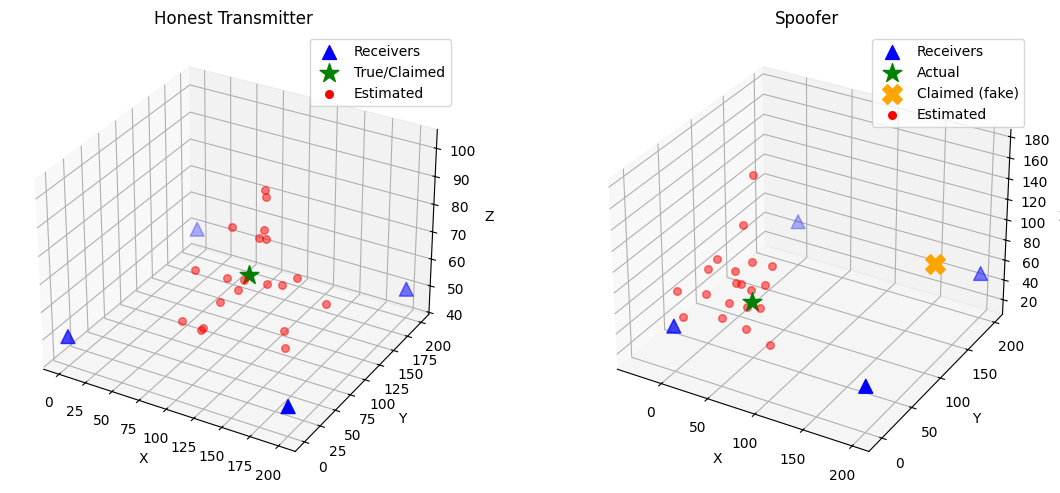

Left: Honest - estimated positions cluster around true/claimed position
Right: Spoofer - estimated positions cluster around ACTUAL position, far from claimed


In [7]:
fig = plt.figure(figsize=(12, 5))

# Honest case
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(receivers[:, 0], receivers[:, 1], receivers[:, 2], c='blue', s=100, marker='^', label='Receivers')
ax1.scatter(*tx_true, c='green', s=200, marker='*', label='True/Claimed')

# Estimated positions with noise (multiple trials)
np.random.seed(0)
for _ in range(20):
    rssi_noisy = distance_to_rssi(true_distances, tx_power) + np.random.randn(4) * 2
    _, est, _ = detect_spoofing(receivers, rssi_noisy, tx_true)
    if est is not None:
        ax1.scatter(*est, c='red', s=30, alpha=0.5)

ax1.scatter([], [], c='red', s=30, label='Estimated')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.set_title('Honest Transmitter')
ax1.legend()

# Spoofer case
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(receivers[:, 0], receivers[:, 1], receivers[:, 2], c='blue', s=100, marker='^', label='Receivers')
ax2.scatter(*tx_actual, c='green', s=200, marker='*', label='Actual')
ax2.scatter(*tx_claimed, c='orange', s=200, marker='X', label='Claimed (fake)')

np.random.seed(0)
for _ in range(20):
    rssi_noisy = distance_to_rssi(actual_distances, tx_power) + np.random.randn(4) * 2
    _, est, _ = detect_spoofing(receivers, rssi_noisy, tx_claimed)
    if est is not None:
        ax2.scatter(*est, c='red', s=30, alpha=0.5)

ax2.scatter([], [], c='red', s=30, label='Estimated')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.set_title('Spoofer')
ax2.legend()

plt.tight_layout()
plt.show()

print("Left: Honest - estimated positions cluster around true/claimed position")
print("Right: Spoofer - estimated positions cluster around ACTUAL position, far from claimed")

## Step 5: Load Real Data

In [8]:
import sys
sys.path.insert(0, '../..')
from evaluations.data import load_scenario
from evaluations.detectors import MultilatDetector

scenario = load_scenario('../../datasets/scitech26/train/0a293ed9-b.csv')
print(f"Scenario: {scenario.scenario_id}")
print(f"Total RX events: {scenario.n_events}")
print(f"Spoofed: {scenario.n_spoofed}, Benign: {scenario.n_benign}")
print(f"\nFederate host IDs: {scenario.federate_host_ids}")
print("(First 4 benign hosts designated as ground station receivers)")

Scenario: 0a293ed9-b
Total RX events: 10123
Spoofed: 1404, Benign: 8719

Federate host IDs: [0 1 4 5]
(First 4 benign hosts designated as ground station receivers)


In [ ]:
# Run multilateration detector with joint TX power estimation
# - Uses only federate receivers (first 4 benign hosts)
# - Groups transmissions by (serial_number, rid_timestamp)
# - Jointly solves for position AND TX power via nonlinear least squares
# - Computes position error = |estimated_pos - claimed_pos|
# - Filters position error with a KF per transmitter (by serial number)
# - Returns filtered error as detection score

detector = MultilatDetector(
    path_loss_exp=2.0,
    min_federates=4,
)
scores = detector.score(scenario)

print(f"Detection parameters: {detector.params}")
print(f"\nScores computed: {len(scores)}")
print(f"Non-zero scores: {(scores > 0).sum()}")
print(f"(Events without 4 federates get score 0)")

# Compare spoofed vs benign
valid = scores > 0
scores_benign = scores[(~scenario.is_spoofed) & valid]
scores_spoofed = scores[scenario.is_spoofed & valid]

print(f"\nBenign filtered errors:  mean={np.mean(scores_benign):.1f}m, median={np.median(scores_benign):.1f}m")
print(f"Spoofed filtered errors: mean={np.mean(scores_spoofed):.1f}m, median={np.median(scores_spoofed):.1f}m")

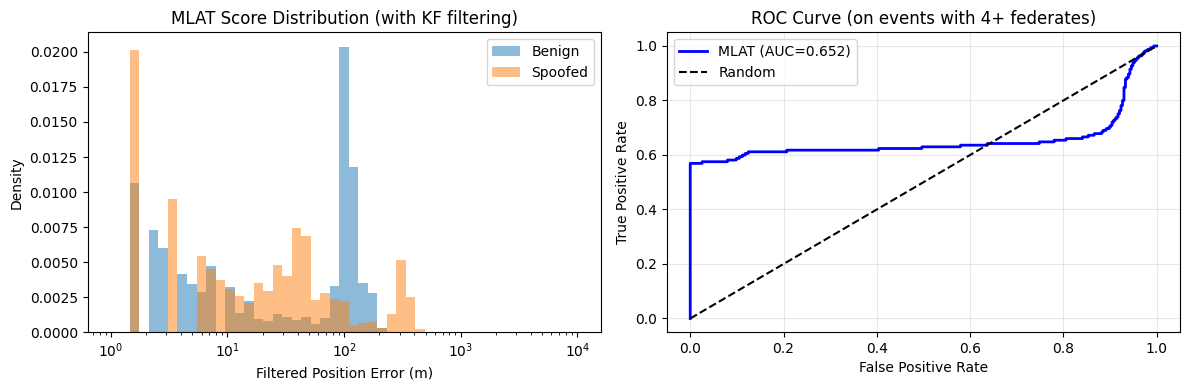

AUC: 0.6520


In [10]:
# Plot score distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram (log scale for x-axis due to large range)
ax = axes[0]
bins = np.logspace(0, 4, 50)  # 1m to 10000m
ax.hist(scores_benign, bins=bins, alpha=0.5, label='Benign', density=True)
ax.hist(scores_spoofed, bins=bins, alpha=0.5, label='Spoofed', density=True)
ax.set_xscale('log')
ax.set_xlabel('Filtered Position Error (m)')
ax.set_ylabel('Density')
ax.set_title('MLAT Score Distribution (with KF filtering)')
ax.legend()

# ROC curve
from evaluations.metrics import compute_roc_auc
auc, fpr, tpr, thresholds = compute_roc_auc(scenario.is_spoofed[valid], scores[valid])

ax = axes[1]
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'MLAT (AUC={auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (on events with 4+ federates)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"AUC: {auc:.4f}")

## Step 6: Parameter Tuning

The main parameter to optimize is the **path loss exponent** (n in the RSSI model). We use line search over candidate values:

- **path_loss_exp**: Path loss exponent (2.0 for free space, higher for urban environments with obstacles)
  - Typical search range: [1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

Other parameters have reasonable defaults:
- **min_federates**: Minimum federate receivers for multilateration (typically 4, the minimum for 4 unknowns)
- **kf_process_noise**: KF process noise for error tracking (default 100.0)
- **kf_measurement_noise**: KF measurement noise based on typical multilateration error variance (default 250000.0, ~500m std dev)

In [ ]:
# Line search over path loss exponent on single scenario
results = []

for ple in [1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]:
    detector = MultilatDetector(
        path_loss_exp=ple,
        min_federates=4,
    )
    scores = detector.score(scenario)
    valid = scores > 0
    if valid.sum() > 0:
        auc, _, _, _ = compute_roc_auc(scenario.is_spoofed[valid], scores[valid])
        results.append((ple, auc, valid.sum()))

# Show results
print(f"{'Path Loss Exp':>14} {'AUC':>8} {'Events':>8}")
print("-" * 34)
for ple, auc, n_events in sorted(results, key=lambda x: -x[1]):
    print(f"{ple:>14.1f} {auc:>8.4f} {n_events:>8}")

## Summary

**The Federated Multilateration detection pipeline:**

1. **Fixed federates**: First 4 benign hosts act as ground station receivers
2. **Transmission grouping**: Group RX events by `(serial_number, rid_timestamp)` to identify the same transmission
3. **Joint estimation**: Solve for both position (x,y,z) AND TX power simultaneously using nonlinear least squares
   - Measurement model: $RSSI_i = P_{tx} - 10n\log_{10}(|pos - r_i|)$
   - 4 unknowns, 4+ measurements → overdetermined system
4. **Position error**: Compute |estimated_pos - claimed_pos|
5. **KF filtering**: Track position error per transmitter (by serial number)
6. **Detection score**: Filtered position error (large error = likely spoofing)

**Key insight:** By solving for TX power jointly with position, we don't need to assume the claimed position is correct. This makes the detector more robust.

**Parameter optimization:**
- Line search over path loss exponent [1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
- Threshold selected by maximizing Youden's J statistic (TPR - FPR)
- Evaluation reports both training and test set performance

**Strengths:**
- Directly estimates transmitter location without trusting claimed position
- Hard for spoofer to defeat (would need to control RSSI at multiple receivers)
- KF filtering smooths noisy estimates and builds confidence
- Provides position estimate, not just detection
- Lower false positive rate compared to single-receiver KF approach

**Weaknesses:**
- Requires 4+ federate receivers to receive the same transmission
- Sensitive to path loss model parameters
- Sensitive to receiver geometry (DOP - Dilution of Precision)
- Computationally more expensive (nonlinear optimization per transmission)
- Higher latency (must wait for observations from multiple federates)

**Comparison to KF Detector:**
- KF detector: Each receiver independently tracks TX power inconsistency → fast (3s TTD), higher FPR
- MLAT detector: Federates collaborate to estimate position → slower (66s TTD), lower FPR
- Complementary deployment: KF for onboard real-time, MLAT for ground station monitoring